In [13]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn import  linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from sklearn.model_selection import GridSearchCV
import math as ma
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import autograd.numpy as np

# To do elementwise differentiation:
from autograd import elementwise_grad as egrad 
from autograd import grad

In [14]:
#Functions for R2 and MSE
def R2(y_data, y_model):
    return 1 - np.sum((y_data - y_model) ** 2) / np.sum((y_data - np.mean(y_data)) ** 2)
def MSE(y_data,y_model):
    n = np.size(y_model)
    return np.sum((y_data-y_model)**2)/n

In [15]:
def noiseGeneration(z_input, scaling = 0.1):
    
    nosyZ= z_input + np.random.randn(*z_input.shape) * scaling
    return nosyZ

In [16]:
def X_generator(x, y, n):
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)

    N = len(x)
    l = int((n+1)*(n+2)/2)  # Number of elements in beta
    X = np.ones((N,l))

    for i in range(1,n+1):
        q = int((i)*(i+1)/2)
        for k in range(i+1):
            X[:,q+k] = (x**(i-k))*(y**k)

    return X

In [17]:
# Franke Function
def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

In [18]:
# split in training and test data
def traningDataGenerator(X,z):
    X_train, X_test, y_train, y_test = train_test_split(X,z,test_size=0.2, random_state= 11)
    return X_train, X_test, y_train, y_test

In [19]:
#Scaling function for the feature matrix
def scale(X_train,X_test,y_train,y_test):
    scaler = StandardScaler(with_std=True)
    scaler_x = scaler.fit(X_train) # Scaling x-data
    X_train_scaled = scaler_x.transform(X_train)
    X_test_scaled = scaler_x.transform(X_test)
    
    
    #scaler_y = np.mean(y_train)
    #y_train_scaled = y_train - scaler_y
    #y_test_scaled = y_test - scaler_y
    scaler_y = scaler.fit(y_train.reshape(-1,1))
    y_train_scaled = scaler_y.transform(y_train.reshape(-1,1)).ravel()
    y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).ravel()
    return X_train_scaled,X_test_scaled,y_train_scaled,y_test_scaled

In [20]:
def plot_z(x,y,z,title):
    from mpl_toolkits.mplot3d import Axes3D
    from matplotlib import cm
    from matplotlib.ticker import LinearLocator, FormatStrFormatter
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(x_mesh, y_mesh, z, cmap=cm.coolwarm,linewidth=0, antialiased=False)
    # Customize the z axis.
    ax.set_zlim(-0.10, 1.40)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.title("{}".format(title))
    plt.show()

# Initializing start Data

In [21]:
x = np.linspace(0,1,20)
y = np.linspace(0,1,20)
x_mesh,y_mesh = np.meshgrid(x,y)
x_flat = x_mesh.ravel()
y_flat = y_mesh.ravel()

z = FrankeFunction(x_flat,y_flat)

# Defining standard gradient descent for Ridge

In [22]:
def Hessian_eta_Ridge(X_train,lmb,n):
    XT_X = X_train.T @ X_train
    Id = n*lmb* np.eye(XT_X.shape[0])


    H = (2.0/n)* XT_X+2*lmb* np.eye(XT_X.shape[0])
    EigValues, EigVectors = np.linalg.eig(H)
    eta = 1.0/np.max(EigValues)
    eta = 1.0/np.max(EigValues)
 
    return eta

In [23]:
def grad_descent_ridge(X_train,y_train,eta,lmb):
    
    np.random.seed(644)
    converge_criteria = 10 # some initial value
    cond = 0
    gradient_n = 0
    beta = np.random.randn(X_train.shape[1]) -0.5 # Picking out initial beta values. 
    while converge_criteria > 1e-8:
        dc_db = (2.0/len(X_train))*X_train.T @ (X_train @ (beta)- y_train) + 2*lmb*beta # derivative of the cost function
        converge_criteria = np.linalg.norm(dc_db-gradient_n)
        gradient_n = dc_db #gradient n-1
        beta = beta - eta*dc_db
        cond += 1 
        if cond > 20000:
            converge_criteria = 0
    theta_gd = beta
    return theta_gd , cond

In [24]:
def grad_descent_ridge_momentum(X_train,y_train,eta,lmb,gamma=0.9):
    np.random.seed(644)
    v_initial  = 0 #start the velocity term at zero
    beta = np.random.randn(X_train.shape[1]) - 0.5 # Picking out initial beta values.
    itter = 0 # number of itterations needed to converge
    converge_criteria = 20 # some inital value
    while converge_criteria > 1e-8:
        dc_db = (2.0/len(X_train))*X_train.T @ (X_train @ (beta)- y_train) + 2*lmb*beta # derivative of the cost function
        
        v_vector = gamma*v_initial + eta*dc_db
        beta = beta - v_vector
        converge_criteria = np.linalg.norm(v_vector-v_initial)
        v_initial = v_vector
        itter += 1
        if itter > 20000:
            converge_criteria = 0
    theta_moment = beta
    return theta_moment,itter

# Own written grid search algorithm for oprimal lambda eta combo

In [25]:
def optimal_eta_lambda_combo_GD(X_train,y_train,algo = "velo"):
    np.random.seed(644)
    x = X_train
    y = y_train
    numberOfLambdas = 20
    theta_j = 0
    itter_j = 0
    numberOfEtas = 5
    etas = np.logspace(-5,-1,numberOfEtas)
    lambdas = np.logspace(-4,4,numberOfLambdas)
    bestLambda_index = 0
    bestEta_index = 0
    mse_eta_train_ridg = np.zeros((numberOfLambdas,len(etas)))
    for i in range(numberOfLambdas):
        lmb = lambdas[i]
        for j in range(numberOfEtas):
            eta = etas[j]
            if algo == "velo":
                theta_j,itter_j = grad_descent_ridge_momentum(x,y,eta,lmb)
            elif algo == "plain":
                theta_j,itter_j = grad_descent_ridge(x,y,eta,lmb)
            else:
                return print("this is not a valid choice, Pick momentum or plain")
            z_tilde_ols = x @ theta_j
            mse_eta_train_ridg[i,j] = MSE(z_train,z_tilde_ols)
           
            if mse_eta_train_ridg[i,j] < mse_eta_train_ridg[i,bestEta_index]:
                    bestEta_index = j
        if mse_eta_train_ridg[i,bestEta_index] < mse_eta_train_ridg[bestLambda_index,bestEta_index]:
            bestLambda_index = i
        
    return lambdas[bestLambda_index], etas[bestEta_index]#, Best lambda and eta based on 

In [26]:
def optimal_eta_lambda_combo_pandas(X_train,y_train,algo = "velo"):
    np.random.seed(644)
    x = X_train
    y = y_train
    numberOfLambdas = 20
    theta_j = 0
    itter_j = 0
    numberOfEtas = 5
    etas = np.logspace(-5,-1,numberOfEtas)
    lambdas = np.logspace(-4,4,numberOfLambdas)
    bestLambda_index = 0
    bestEta_index = 0
    mse_eta_train_ridg = np.zeros((numberOfLambdas,len(etas)))
    for i in range(numberOfLambdas):
        lmb = lambdas[i]
        for j in range(numberOfEtas):
            eta = etas[j]
            if algo == "velo":
                theta_j,itter_j = grad_descent_ridge_momentum(x,y,eta,lmb)
            elif algo == "plain":
                theta_j,itter_j = grad_descent_ridge(x,y,eta,lmb)
            else:
                return print("this is not a valid choice, Pick momentum or plain")
            z_tilde_ols = x @ theta_j
            mse_eta_train_ridg[i,j] = MSE(z_train,z_tilde_ols)
    df_grid_lambdas = pd.DataFrame(mse_eta_train_ridg, index = lambdas,columns = etas)
    return df_grid_lambdas.idxmin()
            

# Checking witch polynomial to be conducted further While comparing itteration and MSE for Momentum VS non-Momentum

C:\Users\Lasse\AppData\Local\Temp/ipykernel_18064/2499924603.py:6: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


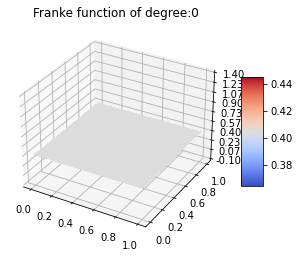

C:\Users\Lasse\AppData\Local\Temp/ipykernel_18064/2499924603.py:6: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


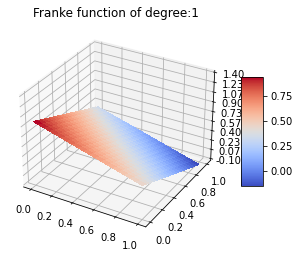

C:\Users\Lasse\AppData\Local\Temp/ipykernel_18064/2499924603.py:6: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


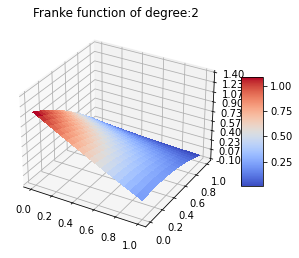

C:\Users\Lasse\AppData\Local\Temp/ipykernel_18064/2499924603.py:6: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


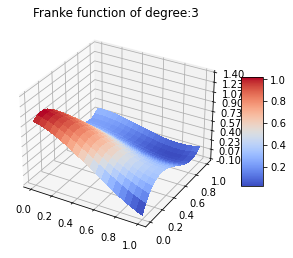

C:\Users\Lasse\AppData\Local\Temp/ipykernel_18064/2499924603.py:6: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


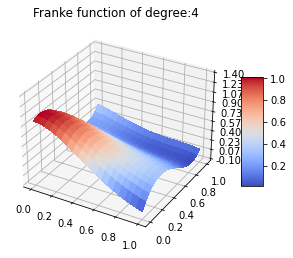

C:\Users\Lasse\AppData\Local\Temp/ipykernel_18064/2499924603.py:6: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


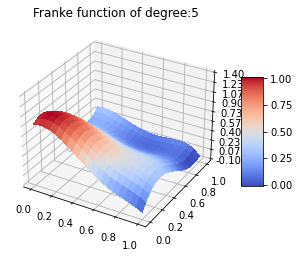

C:\Users\Lasse\AppData\Local\Temp/ipykernel_18064/2499924603.py:6: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


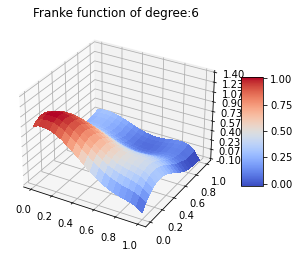

C:\Users\Lasse\AppData\Local\Temp/ipykernel_18064/2499924603.py:6: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


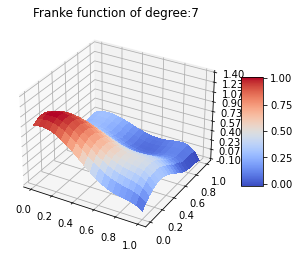

C:\Users\Lasse\AppData\Local\Temp/ipykernel_18064/2499924603.py:6: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


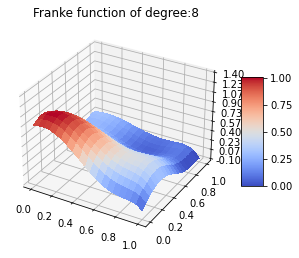

C:\Users\Lasse\AppData\Local\Temp/ipykernel_18064/2499924603.py:6: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


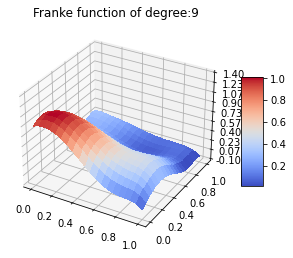

C:\Users\Lasse\AppData\Local\Temp/ipykernel_18064/2499924603.py:6: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


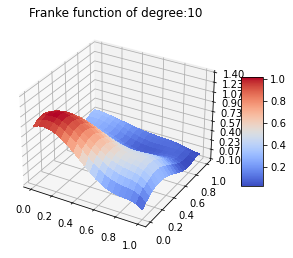

In [41]:

max_degree = 10


lmb = 0.00001

mse_mom = []
itter_mom = []
r2_mom = []

mse_gd = []
itter_gd = []
r2_gd = []

poly = []

z_mesh = FrankeFunction(x_mesh,y_mesh)

for i in range(0, max_degree + 1):
    poly.append(i)
    X = X_generator(x_flat,y_flat,i)
    
    X_train,X_test,z_train,z_test = traningDataGenerator(X,z)
    eta = Hessian_eta_Ridge(X_train,lmb,len(X_train))
    theta_mom,itter_gd_mom = grad_descent_ridge_momentum(X_train,z_train,eta,lmb)
    theta,itter= grad_descent_ridge(X_train,z_train,eta,lmb)
    
    itter_mom.append(itter_gd_mom)
    itter_gd.append(itter)
    
    z_pred_mom = X_test@theta_mom
    z_pred_gd = X_test@theta
    
    mse_mom.append(mean_squared_error(z_test,z_pred_mom))
    mse_gd.append(mean_squared_error(z_test,z_pred_gd))
    
    
    
    r2_mom.append(r2_score(z_test,z_pred_mom))
    r2_gd.append(r2_score(z_test,z_pred_gd))
    
    z_plot = X @ theta_mom
    z_plot = z_plot.reshape(z_mesh.shape)
    plot_z(x_mesh,y_mesh,z_plot,"Franke function of degree:{}".format(i))
    
    
    

In [42]:
df_Gd_hessian = pd.DataFrame({"GD MSE moment":mse_mom,"converg itter_moment":itter_mom,\
                              "plain GD MSE":mse_gd,"converg itter_plain":itter_gd})

df_Gd_hessian

,GD MSE moment,converg itter_moment,plain GD MSE,converg itter_plain
0,0.077918,320,0.077918,3
1,0.021853,320,0.021853,357
2,0.016971,666,0.016965,5145
3,0.008949,9425,0.009663,20001
4,0.007935,20001,0.009489,20001
5,0.006078,20001,0.009133,16378
6,0.005465,18859,0.007979,20001
7,0.005148,18640,0.007766,20001
8,0.004725,19602,0.007072,20001
9,0.004441,20001,0.007172,20001


In [22]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import SGDRegressor
ridge_params = {'alpha':np.logspace(-5,5,100),"eta0":np.logspace(-7,-1,7)}
max_degree = 10

X = X_generator(x_flat,y_flat,6)
X_train,X_test,z_train,z_test = traningDataGenerator(X,z)
model = SGDRegressor()
rsearch = RandomizedSearchCV(estimator=model, param_distributions=ridge_params, n_iter=100)
rsearch.fit(X_train,z_train)
print("best score:",rsearch.best_score_)
print("best lambda value",rsearch.best_estimator_.alpha)
print("best inital eta",rsearch.best_estimator_.eta0)
    


best score: 0.6959483251673655
best lambda value 0.00032745491628777284
best inital eta 0.1


# Comparing number of itterations and MSE for different values of eta and Lambda

In [47]:
z = FrankeFunction(x_flat,y_flat)
z = noiseGeneration(z)


theta_i_hessian = 0
itter_i_hessian = 0

etas = np.logspace(-7,-1,7)
lambdas = np.logspace(-5,1,5)
mse_ridge_gd_poly_hessian = np.zeros((len(etas),len(lambdas)))
ridge_gd_itter_hessian = np.zeros((len(etas),len(lambdas)))

theta_i_opti = 0
itter_i_opti = 0
ridge_gd_itter_opti = np.zeros((len(etas),len(lambdas)))
mse_ridge_gd_opti = np.zeros((len(etas),len(lambdas)))



z_mesh = FrankeFunction(x_mesh,y_mesh)
X = X_generator(x_flat,y_flat,6)
X_train,X_test,z_train,z_test = traningDataGenerator(X,z)

for i in range(len(etas)):
    eta = etas[i]
    for j in range(len(lambdas)):
        lmb = lambdas[j]
        eta_h = Hessian_eta_Ridge(X,lmb,len(X[0]))
        #sending to functions
        theta_i_hessian,itter_i_hessian = grad_descent_ridge_momentum(X_train,z_train,eta_h,lmb) # Hessian calculations
        theta_i_opti, itter_i_opti = grad_descent_ridge_momentum(X_train,z_train,eta,lmb)
        #appending the itterations to lists for comparisons
        ridge_gd_itter_hessian[i,j]= itter_i_hessian
        ridge_gd_itter_opti[i,j] = itter_i_opti
        #making predictions
        z_pred_ridge_opti = X_test @ theta_i_opti
        z_pred_ridge_h = X_test @ theta_i_hessian
        mse_ridge_gd_opti[i,j] = mean_squared_error(z_test,z_pred_ridge_opti)
        mse_ridge_gd_poly_hessian[i,j] = mean_squared_error(z_test,z_pred_ridge_h)
        
df_mse_heatmap_ridge = pd.DataFrame(mse_ridge_gd_opti,index = etas,columns = lambdas)
df_itter_heatmap_ridge = pd.DataFrame(ridge_gd_itter_opti,index = etas,columns = lambdas)

                                    
                                    

In [46]:
df_mse_heatmap_ridge

,0.000010,0.000316,0.010000,0.316228,10.000000
1.000000e-07,38.411221,38.411220,38.411161,38.408887,38.317562
1.000000e-06,38.212608,38.212583,38.211772,38.181956,0.234776
1.000000e-05,0.510489,0.509849,0.490330,0.121003,0.189037
1.000000e-04,0.121352,0.120856,0.102527,0.072053,0.188927
1.000000e-03,0.031470,0.030911,0.026550,0.071857,0.188926
1.000000e-02,0.020312,0.020930,0.026454,0.071856,0.188927
1.000000e-01,0.015062,0.020883,0.026454,0.071856,0.188926


Text(0.5, 1.0, 'test MSE as a function of eta and lambdas')

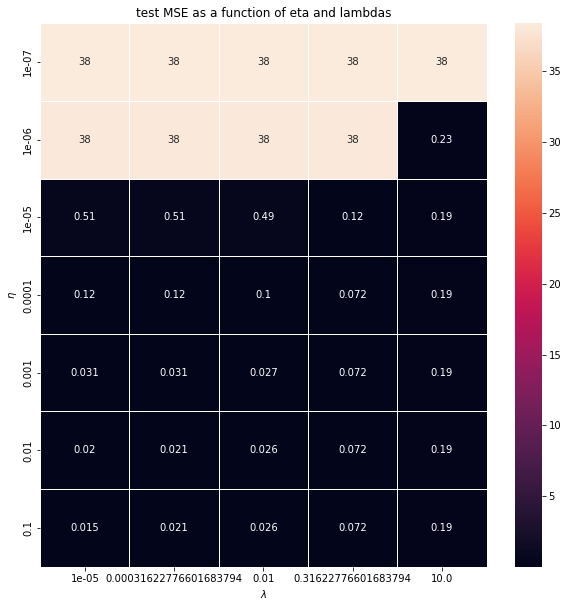

In [53]:
fig, ax = plt.subplots(figsize=(10,10))   
sns.heatmap(df_mse_heatmap_ridge,annot =True, linewidths=.8, ax=ax,fmt='.2g')
ax.set_xlabel(r'$\lambda$')
ax.set_ylabel(r'$\eta$')
ax.set_title("test MSE as a function of eta and lambdas")


Text(0.5, 1.0, 'itterations as a function of eta and lambdas')

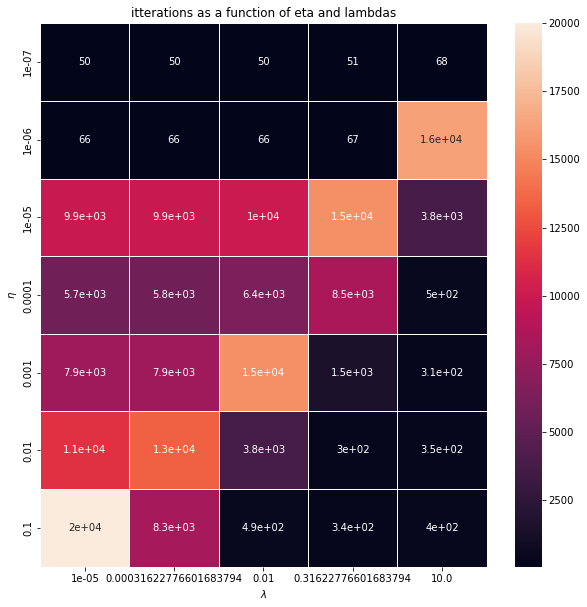

In [54]:
fig, ax = plt.subplots(figsize=(10,10))   
sns.heatmap(df_itter_heatmap_ridge,annot =True, linewidths=.8, ax=ax,fmt='.2g')
ax.set_xlabel(r'$\lambda$')
ax.set_ylabel(r'$\eta$')
ax.set_title("itterations as a function of eta and lambdas")

# Stochastic gradient descent for ridge

In [56]:
x = np.linspace(0,1,20)
y = np.linspace(0,1,20)
x_mesh,y_mesh = np.meshgrid(x,y)
x_flat = x_mesh.ravel()
y_flat = y_mesh.ravel()

z = FrankeFunction(x_flat,y_flat)

Mini batches function

In [57]:
def mini_batch_creator(X, y, batch_size):
        mini_batches = [] # empty list for the mini batchess
        data_matrix = np.hstack((X, y.reshape(-1, 1)))  # Column 0 to n-1 is data, column n is the target data
        
        np.random.shuffle(data_matrix) # would not be stochastic if it didnt include random. 
        
        m = data_matrix.shape[0] // batch_size # number of minibatches number of rows/datapoints divided by selected batchsize
        i=0
        for i in range(m):
            mini_batch = data_matrix[i * batch_size:(i + 1)*batch_size, :]#creating a mini batch
            X_mini = mini_batch[:, :-1] #evry thing except the last column
            Y_mini = mini_batch[:, -1] #exclusively the last column
            mini_batches.append((X_mini, Y_mini)) # has 2 arrays, first array contains the minibatches for x and the second for y
        if data_matrix.shape[0] % batch_size != 0:
            mini_batch = data_matrix[i * batch_size:data_matrix.shape[0]]
            X_mini = mini_batch[:, :-1]
            Y_mini = mini_batch[:, -1]
            mini_batches.append((X_mini, Y_mini))
        return mini_batches

# Cost Fuctions

In [58]:
def Cost_ridge(y,X,theta,lmb):
    return np.sum((y- X @ theta)**2) + np.sum(lmb * (theta)**2)

In [59]:
grad_ridge = grad(Cost_ridge,2)

In [60]:
def learning_schedule(eta,decay,epoch):
    return (eta/(1+decay*epoch))
    

In [61]:
def SGD_ridge(X_train,y_train,n_epochs,batch_size,lmb = 0.0001,eta = 0.1,gamma = 0.9,delta=1e-8,rho = 0.99, algo = "MOM",decay = 1e-5):
    np.random.seed(644)
    
    grad_ridge = grad(Cost_ridge,2)
    gradient_n = 0 #some inital value
    learnin_rate = []
    
    #If momentum algorithm
    if algo == "MOM":
        beta = np.random.randn(X_train.shape[1]) # Picking elements in beta, number of columns in design matrix
        beta = beta.reshape(-1,1) #Column vector
        v_previous = 0
        for epoch in range(n_epochs):
            mini_batches = mini_batch_creator(X_train,y_train,batch_size)
            for batch in mini_batches:
                X_mini_i,Y_mini_i = batch
                Y_mini_i = Y_mini_i.reshape(-1,1) # need a column vector
                dc_db = (1/batch_size)*grad_ridge(Y_mini_i,X_mini_i,beta,lmb)
                eta = learning_schedule(eta,decay,epoch)
                v_vector = gamma*v_previous + eta*dc_db
                beta = beta - v_vector
                v_previous = v_vector
            learnin_rate.append(eta)
        theta_moment = beta
       
        return theta_moment
    
    
    # IF RMS Algorithm
    elif algo == "RMS":
        beta = np.random.randn(X_train.shape[1]) # Picking elements in beta, number of columns in design matrix
        beta = beta.reshape(-1,1)
        for epoch in range(n_epochs):
            # The outer product is calculated from scratch for each epoch
            mini_batches = mini_batch_creator(X_train,y_train,batch_size)
            Giter = np.zeros(shape=(len(beta),len(beta)))
            for batch in mini_batches:
                X_mini_i,Y_mini_i = batch
                Y_mini_i = Y_mini_i.reshape(-1,1) # Column vector
                dc_db = (1/batch_size)*grad_ridge(Y_mini_i,X_mini_i,beta,lmb) #g_t in lecture notes
                # Previous value for the outer product of gradients
                Previous = Giter
                # Accumulated gradient
                Giter +=dc_db @ dc_db.T
                # Scaling with rho the new and the previous results
                Gnew = (rho*Previous+(1-rho)*Giter) #s_t in lecture notes
                # Taking the diagonal only and inverting
                Ginverse = np.c_[eta/(delta+np.sqrt(np.diagonal(Gnew)))]
                # Hadamard product
                update = np.multiply(Ginverse,dc_db)
                beta -= update
        theta = beta
        return theta
    
    
        
        
        
        
    #If Adagrad algorithm 
    elif algo == "ADG":
        beta = np.random.randn(X_train.shape[1]) # Picking elements in beta, number of columns in design matrix
        beta = beta.reshape(-1,1)
        i = 0
        for epoch in range(n_epochs):
            # The outer product is calculated from scratch for each epoch
            mini_batches = mini_batch_creator(X_train,y_train,batch_size)
            Giter = np.zeros(shape=(len(beta),len(beta)))
            I = np.eye(len(beta))
            for batch in mini_batches:
                X_mini_i,Y_mini_i = batch
                Y_mini_i = Y_mini_i.reshape(-1,1) # Column vector
                dc_db = (1/batch_size)*grad_ridge(Y_mini_i,X_mini_i,beta,lmb)
                # Calculate the outer product of the gradients
                Giter += dc_db @ dc_db.T
                # Simpler algorithm with only diagonal elements
                Ginverse = np.c_[eta/(delta+np.sqrt(np.diagonal(Giter)))]
                # compute update
                update = np.multiply(Ginverse,dc_db)
                beta = beta - update
                i += 1
        theta = beta
        return theta
        
        
    
    
    elif algo == "ADM":
        rho_2 = rho
        rho_1 = 0.9
        beta = np.random.randn(X_train.shape[1]) # Picking elements in beta, number of columns in design matrix
        beta = beta.reshape(-1,1)
        f_m = 0
        s_m = 0
        for epoch in range(1,n_epochs):
            # The outer product is calculated from scratch for each epoch
            mini_batches = mini_batch_creator(X_train,y_train,batch_size)
            for batch in mini_batches:
                X_mini_i,Y_mini_i = batch
                Y_mini_i = Y_mini_i.reshape(-1,1) # Column vector
                dc_db = (1/batch_size)*grad_ridge(Y_mini_i,X_mini_i,beta,lmb) #g_t in lecture notes
                # Previous value for the outer product of gradients
                f_m = rho_1 * f_m + (1-rho_1) *dc_db
                s_m = rho_2 *s_m + (1-rho_2) * dc_db * dc_db
                #Unbias term
                f_b = (f_m/(1-rho_1**epoch)) # First unbias
                s_b = (s_m/(1-rho_2**epoch)) # second unbias
                
                #Uppdate
                update = eta * f_b/(np.sqrt(s_b)+ delta)
                beta -= update
        theta = beta
        return theta
    
    else:
        return "riase error, no valid function was found. Please select one of the following MOD,RMS,ADG,ADM"

In [64]:
z = FrankeFunction(x_flat,y_flat)
z = noiseGeneration(z)
X = X_generator(x_flat,y_flat,6)
X_train,X_test,z_train,z_test = traningDataGenerator(X,z)


batch_size = 20
n_epochs = 60
gammas = np.arange(0.2,0.95,0.05)
decays = np.logspace(-6,-1,6)
deltas = np.logspace(-10,-5,6)
n_epochs_list = np.arange(10,110,10)
lambdas = np.logspace(-5,-1,6)
print(deltas)
print(decays)
print(gammas)

[1.e-10 1.e-09 1.e-08 1.e-07 1.e-06 1.e-05]
[1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]
[0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7  0.75 0.8  0.85
 0.9 ]


In [137]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import SGDRegressor
ridge_params = {'alpha':np.logspace(-7,1,7),"eta0": np.logspace(-6,-1,6)}

max_degree = 10


X = X_generator(x_flat,y_flat,6)
X_train,X_test,z_train,z_test = traningDataGenerator(X,z)
model = SGDRegressor(fit_intercept= False)
rsearch = RandomizedSearchCV(estimator=model, param_distributions=ridge_params, n_iter=100)
rsearch.fit(X_train,z_train)
print("best score:",rsearch.best_score_)
print("best lambda value",rsearch.best_estimator_.alpha)
print("best innitial learning rate",rsearch.best_estimator_.eta0)

C:\Users\Lasse\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 42 is smaller than n_iter=100. Running 42 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


best score: 0.6598942825404082
best lambda value 4.641588833612772e-05
best innitial learning rate 0.1


The Result of sickit learns inital learning rate is also considered to be best at 0.1

In [87]:
etas = np.logspace(-7,-1,7)
lambdas = np.logspace(-5,1,6)
mse_test_mom_eta = np.zeros((len(lambdas),len(etas)))
mse_test_adg_eta = np.zeros((len(lambdas),len(etas)))
mse_test_rms_eta = np.zeros((len(lambdas),len(etas)))
mse_test_adm_eta = np.zeros((len(lambdas),len(etas)))


r2_test_mom_eta = np.zeros((len(lambdas),len(etas)))
r2_test_adg_eta = np.zeros((len(lambdas),len(etas)))
r2_test_rms_eta = np.zeros((len(lambdas),len(etas)))
r2_test_adm_eta = np.zeros((len(lambdas),len(etas)))
theta_j = 0
lr = 0

n_epochs = 100
for i in range(len(lambdas)):
    lmb= lambdas [i]
    for j in range(len(etas)):
        eta = etas[j]
        theta_rms = SGD_ridge(X_train,z_train,n_epochs = n_epochs,batch_size = batch_size,eta=eta,delta = 1e-5,algo = "RMS", lmb = lmb)
        theta_mom = SGD_ridge(X_train,z_train,n_epochs = n_epochs,batch_size = batch_size,eta=eta,decay = 1e-5,gamma = 0.9,algo = "MOM",lmb = lmb)
        theta_adg = SGD_ridge(X_train,z_train,n_epochs = n_epochs,batch_size = batch_size,eta=eta,delta = 1e-5,algo = "ADG",lmb = lmb)
        theta_adm = SGD_ridge(X_train,z_train,n_epochs = n_epochs,batch_size = batch_size,eta=eta,delta = 1e-5,algo = "ADM",lmb = lmb)


        # Predictions
        z_pred_mom = X_test @ theta_mom
        z_pred_rms = X_test @ theta_rms
        z_pred_adg = X_test @ theta_adg
        z_pred_adm = X_test @ theta_adm

        #MSE       
        mse_test_rms_eta[i,j] = mean_squared_error(z_test,z_pred_rms)
        mse_test_mom_eta[i,j] = mean_squared_error(z_test,z_pred_mom)
        mse_test_adg_eta[i,j] = mean_squared_error(z_test,z_pred_adg)
        mse_test_adm_eta[i,j] = mean_squared_error(z_test,z_pred_adm)
        
        #R^2
        r2_test_rms_eta[i,j] = r2_score(z_test,z_pred_rms)
        r2_test_mom_eta[i,j] = r2_score(z_test,z_pred_mom)
        r2_test_adg_eta[i,j] = r2_score(z_test,z_pred_adg)
        r2_test_adm_eta[i,j] = r2_score(z_test,z_pred_adm)



In [88]:
eta_list = []
lambdas_list = []
for i in range(len(lambdas)):
    lambdas_list.append("lambda={}".format(lambdas[i]))
for i in range(len(n_epochs_list)):
    epoch_list.append("n_epochs = {}".format(n_epochs_list[i]))
    
df_mse_heatmap_rms_epoc_lmb = pd.DataFrame(mse_test_rms_eta, index = lambdas_list, columns = etas)
df_mse_heatmap_mom_epoc_lmb = pd.DataFrame(mse_test_mom_eta, index = lambdas_list, columns = etas)
df_mse_heatmap_adg_epoc_lmb= pd.DataFrame(mse_test_adg_eta, index = lambdas_list, columns = etas)
df_mse_heatmap_adm_epoc_lmb = pd.DataFrame(mse_test_adm_eta, index = lambdas_list, columns = etas)
                      
df_r2_heatmap_rms_epoc_lmb = pd.DataFrame(r2_test_rms_eta, index = lambdas_list, columns = etas)
df_r2_heatmap_mom_epoc_lmb = pd.DataFrame(r2_test_mom_eta, index = lambdas_list, columns = etas)
df_r2_heatmap_adg_epoc_lmb= pd.DataFrame(r2_test_adg_eta, index = lambdas_list, columns = etas)
df_r2_heatmap_adm_epoc_lmb = pd.DataFrame(r2_test_adm_eta, index = lambdas_list, columns = etas)

In [107]:
lambdas[3]

0.03981071705534969

Text(0.5, 1.0, 'Adagrad MSE  lambda and eta')

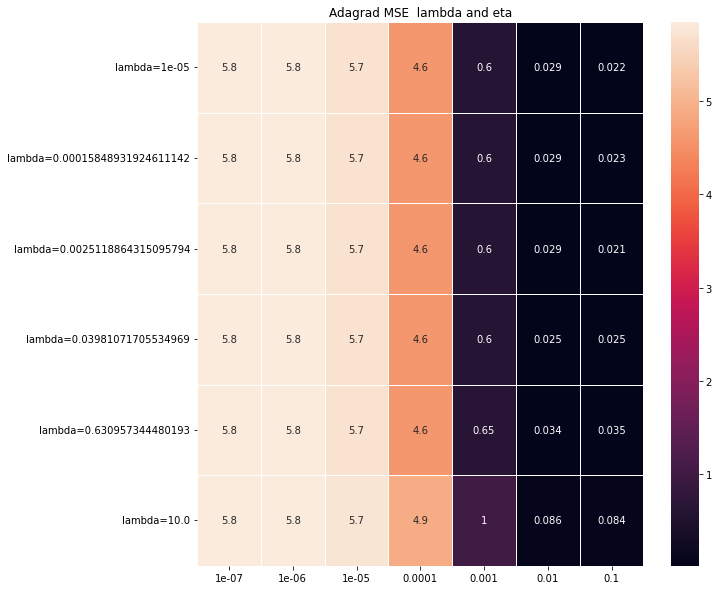

In [89]:
fig, ax = plt.subplots(figsize=(10,10))   
sns.heatmap(df_mse_heatmap_adg_epoc_lmb,annot =True, linewidths=.8, ax=ax,fmt='.2g')
ax.set_title("Adagrad MSE  lambda and eta")

Text(0.5, 1.0, 'Adagrad r2 lambda and eta')

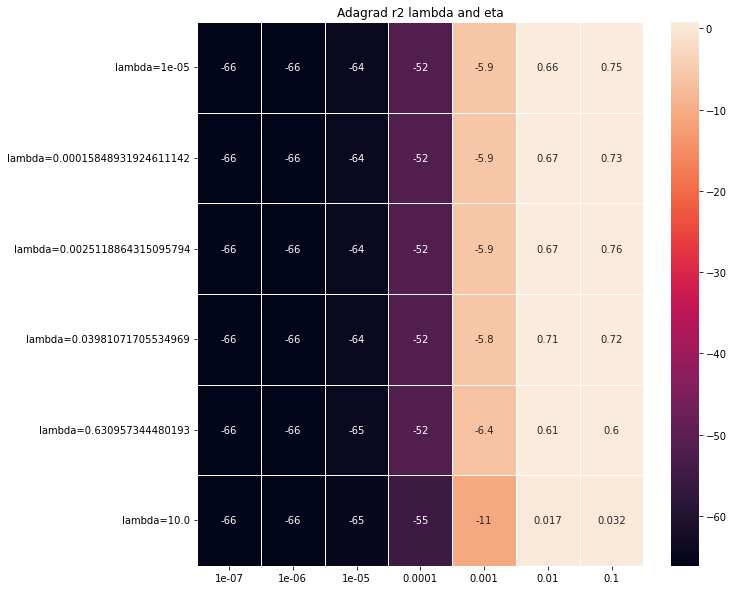

In [100]:
fig, ax = plt.subplots(figsize=(10,10))   
sns.heatmap(df_r2_heatmap_adg_epoc_lmb,annot =True, linewidths=.8, ax=ax,fmt='.2g')
ax.set_title("Adagrad r2 lambda and eta")

In [ ]:
ADG_opti = [lambdas[2],0.1]

Text(0.5, 1.0, 'Adam MSE lambda and eta')

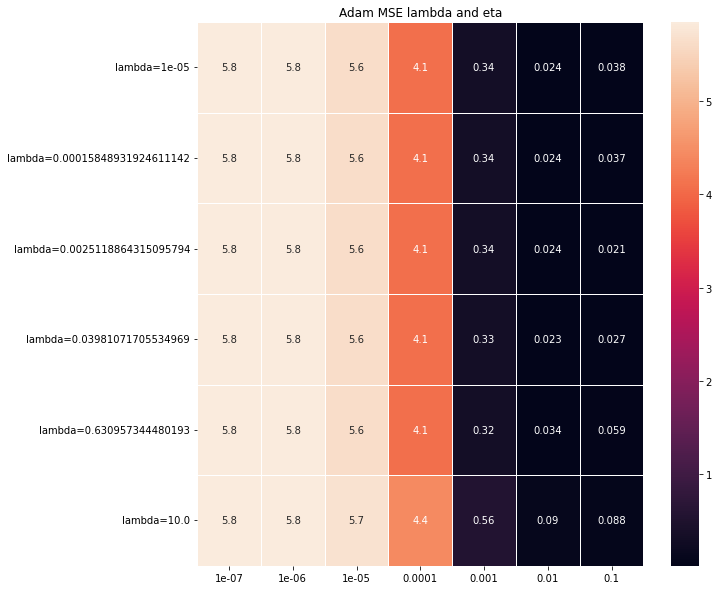

In [90]:
fig, ax = plt.subplots(figsize=(10,10))   
sns.heatmap(df_mse_heatmap_adm_epoc_lmb,annot =True, linewidths=.8, ax=ax,fmt='.2g')
ax.set_title("Adam MSE lambda and eta")

Text(0.5, 1.0, 'Adam r2 lambda and eta')

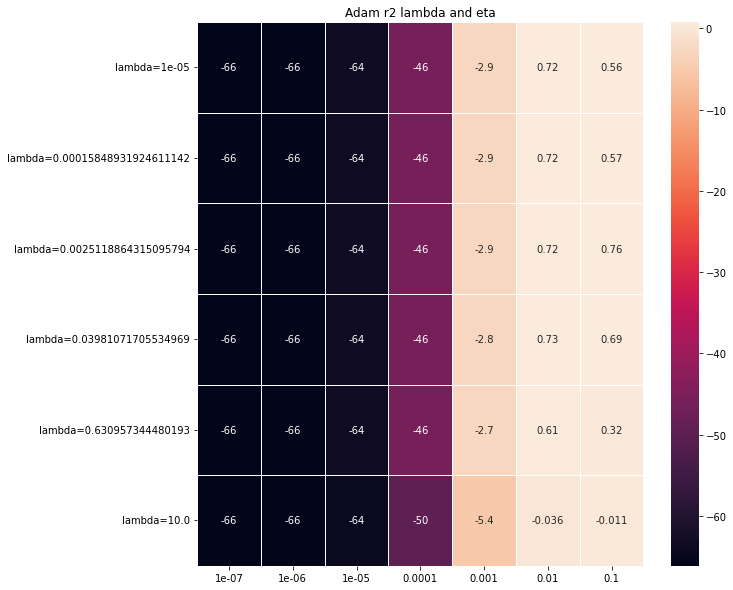

In [101]:
fig, ax = plt.subplots(figsize=(10,10))   
sns.heatmap(df_r2_heatmap_adm_epoc_lmb,annot =True, linewidths=.8, ax=ax,fmt='.2g')
ax.set_title("Adam r2 lambda and eta")

In [128]:
ADM_opti = [lambdas[3],0.1]

Text(0.5, 1.0, 'rms MSE lambda and eta')

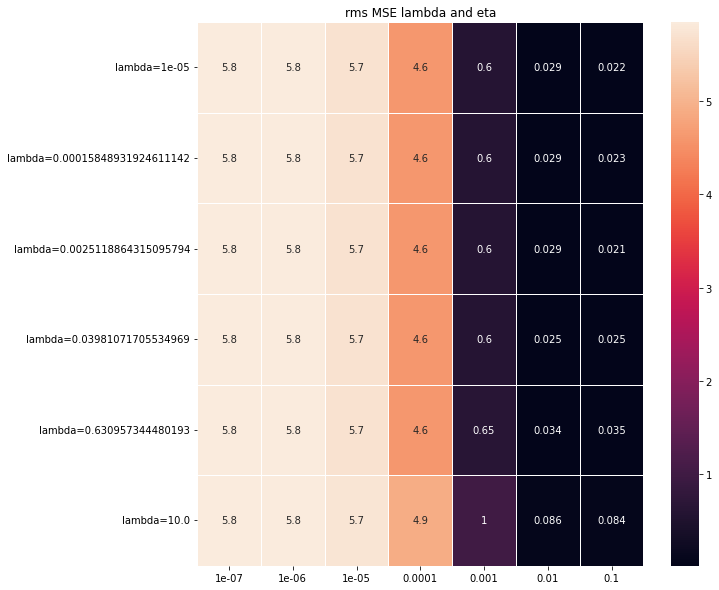

In [91]:
fig, ax = plt.subplots(figsize=(10,10))   
sns.heatmap(df_mse_heatmap_rms_epoc_lmb,annot =True, linewidths=.8, ax=ax,fmt='.2g')
ax.set_title("rms MSE lambda and eta")

Text(0.5, 1.0, 'RMS r2 lambda and eta')

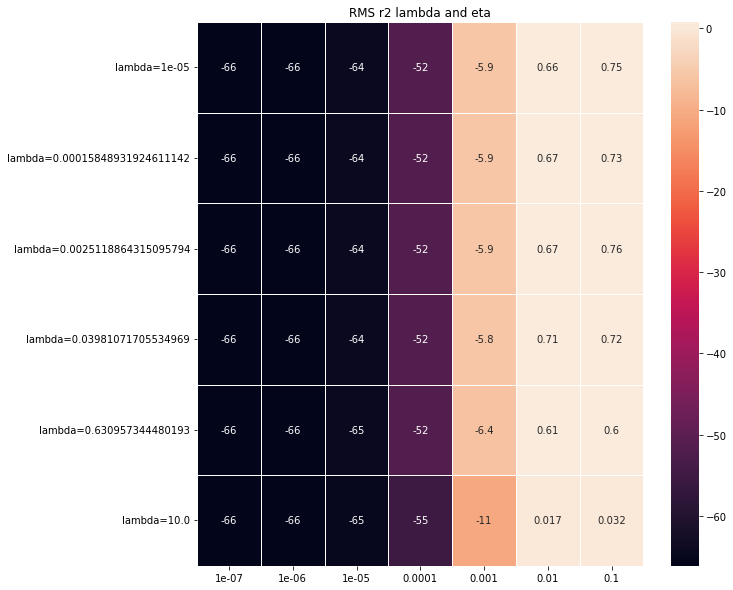

In [102]:
fig, ax = plt.subplots(figsize=(10,10))   
sns.heatmap(df_r2_heatmap_rms_epoc_lmb,annot =True, linewidths=.8, ax=ax,fmt='.2g')
ax.set_title("RMS r2 lambda and eta")

In [131]:
RMS_opti = [lambdas[2],0.1]

Text(0.5, 1.0, 'momentum MSE lambda and eta')

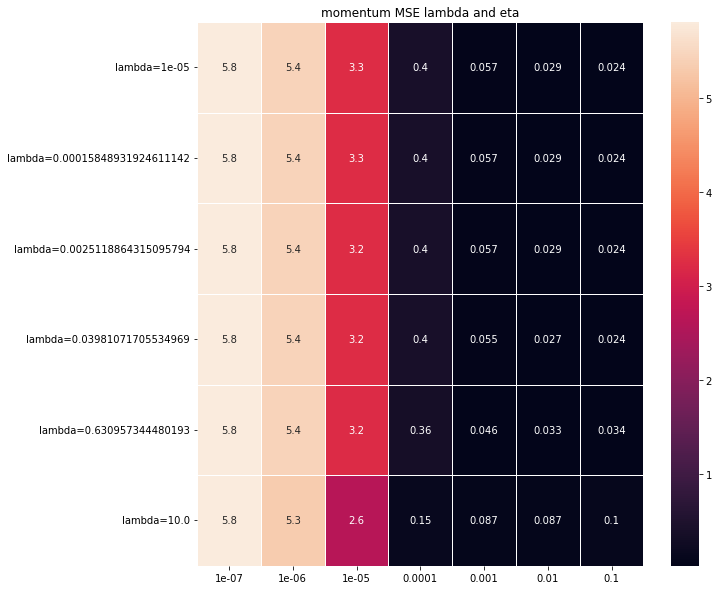

In [92]:
fig, ax = plt.subplots(figsize=(10,10))   
sns.heatmap(df_mse_heatmap_mom_epoc_lmb,annot =True, linewidths=.8, ax=ax,fmt='.2g')
ax.set_title("momentum MSE lambda and eta")

Text(0.5, 1.0, 'momentum r2 lambda and eta')

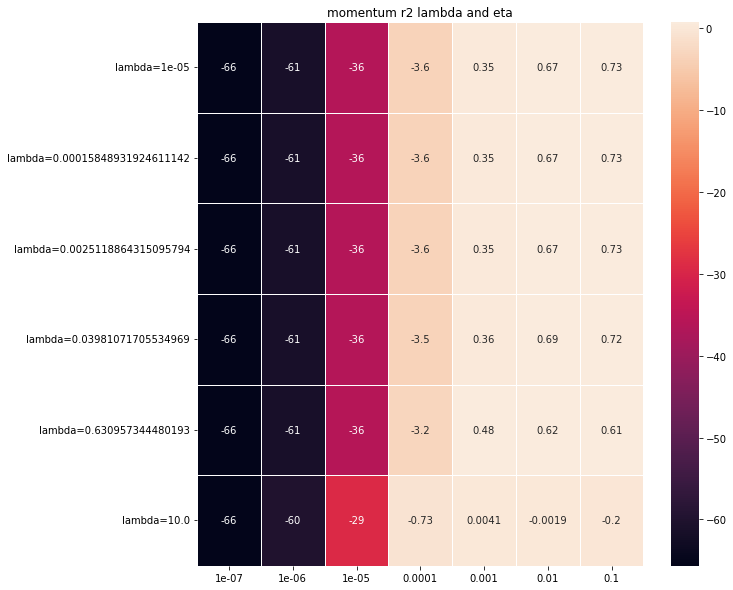

In [95]:
fig, ax = plt.subplots(figsize=(10,10))   
sns.heatmap(df_r2_heatmap_mom_epoc_lmb,annot =True, linewidths=.8, ax=ax,fmt='.2g')
ax.set_title("momentum r2 lambda and eta")

In [106]:
MOM_opti = [1e-5,0.1]

# Tuning lambdas over a given number of epochs Not relevant for report but for personal intrest

In [132]:
n_epochs_list = np.arange(10,110,10)

mse_test_mom_eta = np.zeros((len(lambdas),len(n_epochs_list)))
mse_test_adg_eta = np.zeros((len(lambdas),len(n_epochs_list)))
mse_test_rms_eta = np.zeros((len(lambdas),len(n_epochs_list)))
mse_test_adm_eta = np.zeros((len(lambdas),len(n_epochs_list)))


r2_test_mom_eta = np.zeros((len(lambdas),len(n_epochs_list)))
r2_test_adg_eta = np.zeros((len(lambdas),len(n_epochs_list)))
r2_test_rms_eta = np.zeros((len(lambdas),len(n_epochs_list)))
r2_test_adm_eta = np.zeros((len(lambdas),len(n_epochs_list)))
theta_j = 0
lr = 0
for i in range(len(lambdas)):
    lmb= lambdas [i]
    for j in range(len(n_epochs_list)):
        n_epochs = n_epochs_list[j]
        theta_rms = SGD_ridge(X_train,z_train,n_epochs = n_epochs,batch_size = batch_size,delta = 1e-5,algo = "RMS", lmb = lmb)
        theta_mom = SGD_ridge(X_train,z_train,n_epochs = n_epochs,batch_size = batch_size,decay = 1e-5,gamma = 0.9,algo = "MOM",lmb = lmb)
        theta_adg = SGD_ridge(X_train,z_train,n_epochs = n_epochs,batch_size = batch_size,delta = 1e-5,algo = "ADG",lmb = lmb)
        theta_adm = SGD_ridge(X_train,z_train,n_epochs = n_epochs,batch_size = batch_size,delta = 1e-5,algo = "ADM",lmb = lmb)


        # Predictions
        z_pred_mom = X_test @ theta_mom
        z_pred_rms = X_test @ theta_rms
        z_pred_adg = X_test @ theta_adg
        z_pred_adm = X_test @ theta_adm

        #MSE       
        mse_test_rms_eta[i,j] = mean_squared_error(z_test,z_pred_rms)
        mse_test_mom_eta[i,j] = mean_squared_error(z_test,z_pred_mom)
        mse_test_adg_eta[i,j] = mean_squared_error(z_test,z_pred_adg)
        mse_test_adm_eta[i,j] = mean_squared_error(z_test,z_pred_adm)
        
        #R^2
        r2_test_rms_eta[i,j] = r2_score(z_test,z_pred_rms)
        r2_test_mom_eta[i,j] = r2_score(z_test,z_pred_mom)
        r2_test_adg_eta[i,j] = r2_score(z_test,z_pred_adg)
        r2_test_adm_eta[i,j] = r2_score(z_test,z_pred_adm)


    

KeyboardInterrupt: 

In [67]:
epoch_list = []
lambdas_list = []
for i in range(len(lambdas)):
    lambdas_list.append("lambda={}".format(lambdas[i]))
for i in range(len(n_epochs_list)):
    epoch_list.append("n_epochs = {}".format(n_epochs_list[i]))
    
df_mse_heatmap_rms_epoc_lmb = pd.DataFrame(mse_test_rms_eta, index = lambdas_list, columns = epoch_list)
df_mse_heatmap_mom_epoc_lmb = pd.DataFrame(mse_test_mom_eta, index = lambdas_list, columns = epoch_list)
df_mse_heatmap_adg_epoc_lmb= pd.DataFrame(mse_test_adg_eta, index = lambdas_list, columns = epoch_list)
df_mse_heatmap_adm_epoc_lmb = pd.DataFrame(mse_test_adm_eta, index = lambdas_list, columns = epoch_list)
                      
df_r2_heatmap_rms_epoc_lmb = pd.DataFrame(r2_test_rms_eta, index = lambdas_list, columns = epoch_list)
df_r2_heatmap_mom_epoc_lmb = pd.DataFrame(r2_test_mom_eta, index = lambdas_list, columns = epoch_list)
df_r2_heatmap_adg_epoc_lmb= pd.DataFrame(r2_test_adg_eta, index = lambdas_list, columns = epoch_list)
df_r2_heatmap_adm_epoc_lmb = pd.DataFrame(r2_test_adm_eta, index = lambdas_list, columns = epoch_list)

In [68]:
df_r2_heatmap_adg_epoc_lmb

,n_epochs = 10,n_epochs = 20,n_epochs = 30,n_epochs = 40,n_epochs = 50,n_epochs = 60,n_epochs = 70,n_epochs = 80,n_epochs = 90,n_epochs = 100
lambda=1e-05,0.442614,0.549457,0.609191,0.603119,0.670553,0.145325,0.700009,0.735586,0.725318,0.750248
lambda=6.309573444801929e-05,0.442691,0.549467,0.609602,0.603208,0.670749,0.146814,0.700206,0.735679,0.725492,0.750928
lambda=0.00039810717055349735,0.443157,0.532032,0.613975,0.606804,0.678462,0.119371,0.714012,0.715414,0.667951,0.719560
lambda=0.002511886431509582,0.445921,0.526379,0.605776,0.627172,0.677807,0.117112,0.723774,0.686354,0.669488,0.761523
lambda=0.01584893192461114,0.466321,0.650635,0.639048,0.667159,0.731991,0.324301,0.731872,0.746965,0.691198,0.720042
lambda=0.1,0.604546,0.703820,0.662893,0.690548,0.705037,0.072119,0.714539,0.668123,0.689473,0.683963


Text(0.5, 1.0, 'Adagrad MSE number of mini lambda and epochs')

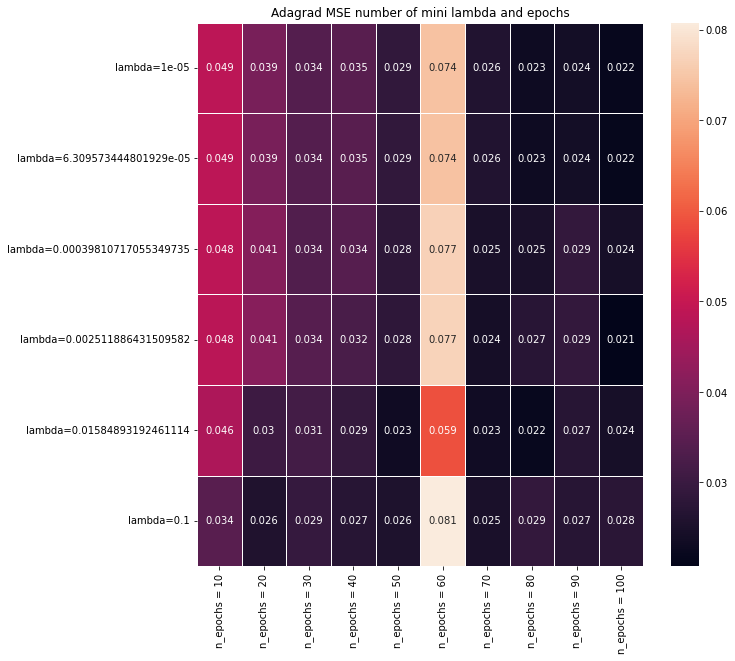

In [78]:
fig, ax = plt.subplots(figsize=(10,10))   
sns.heatmap(df_mse_heatmap_adg_epoc_lmb,annot =True, linewidths=.8, ax=ax,fmt='.2g')
ax.set_title("Adagrad MSE number of mini lambda and epochs")

Text(0.5, 1.0, 'Adam MSE number of mini lambda and epochs')

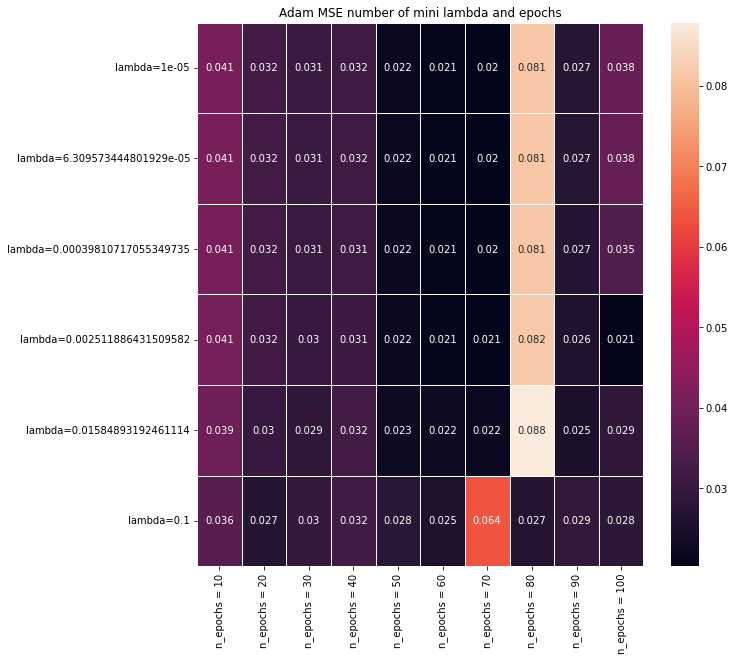

In [77]:
fig, ax = plt.subplots(figsize=(10,10))   
sns.heatmap(df_mse_heatmap_adm_epoc_lmb,annot =True, linewidths=.8, ax=ax,fmt='.2g')
ax.set_title("Adam MSE number of mini lambda and epochs")

Text(0.5, 1.0, 'rms MSE number of mini lambda and epochs')

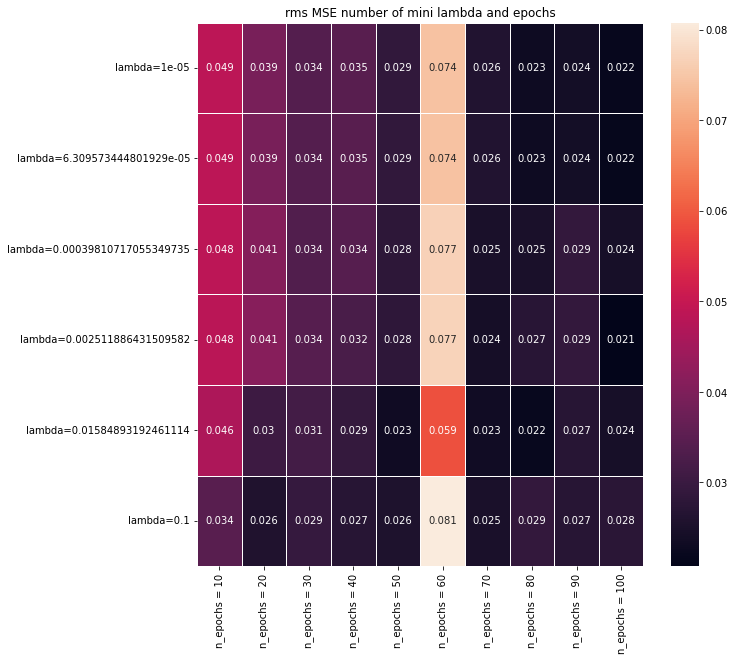

In [79]:
fig, ax = plt.subplots(figsize=(10,10))   
sns.heatmap(df_mse_heatmap_rms_epoc_lmb,annot =True, linewidths=.8, ax=ax,fmt='.2g')
ax.set_title("rms MSE number of mini lambda and epochs")

Text(0.5, 1.0, 'momentum MSE number of mini lambda and epochs')

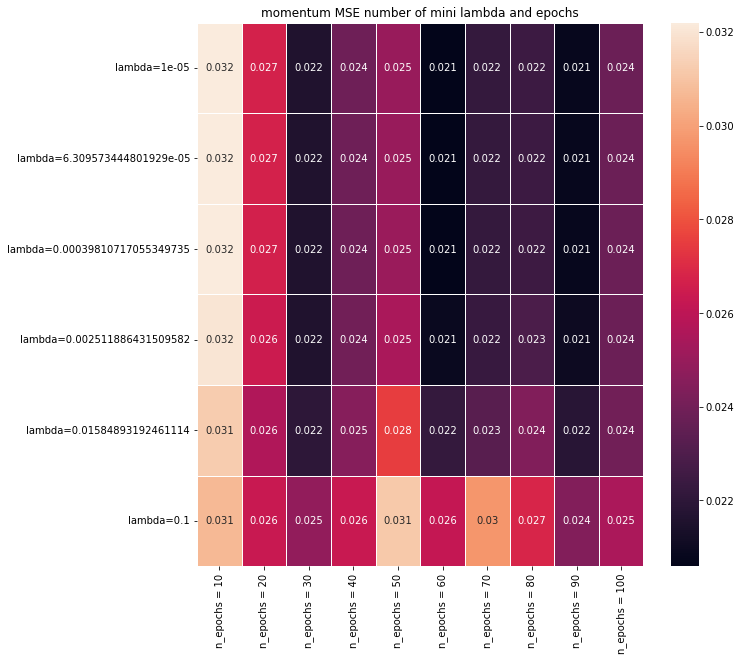

In [80]:
fig, ax = plt.subplots(figsize=(10,10))   
sns.heatmap(df_mse_heatmap_mom_epoc_lmb,annot =True, linewidths=.8, ax=ax,fmt='.2g')
ax.set_title("momentum MSE number of mini lambda and epochs")

Text(0.5, 1.0, 'momentum r2 number of mini lambda and epochs')

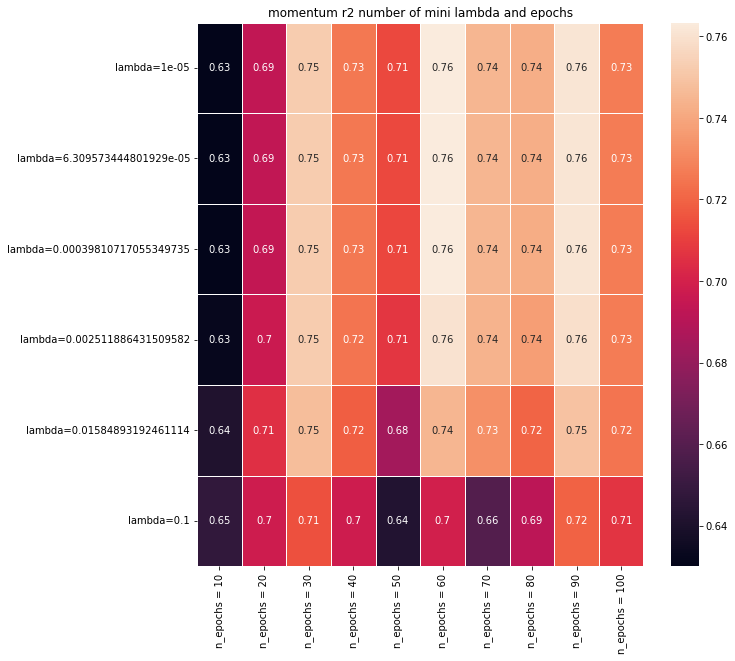

In [81]:
fig, ax = plt.subplots(figsize=(10,10))   
sns.heatmap(df_r2_heatmap_mom_epoc_lmb,annot =True, linewidths=.8, ax=ax,fmt='.2g')
ax.set_title("momentum r2 number of mini lambda and epochs")

Text(0.5, 1.0, 'Adagrad r2 number of mini lambda and epochs')

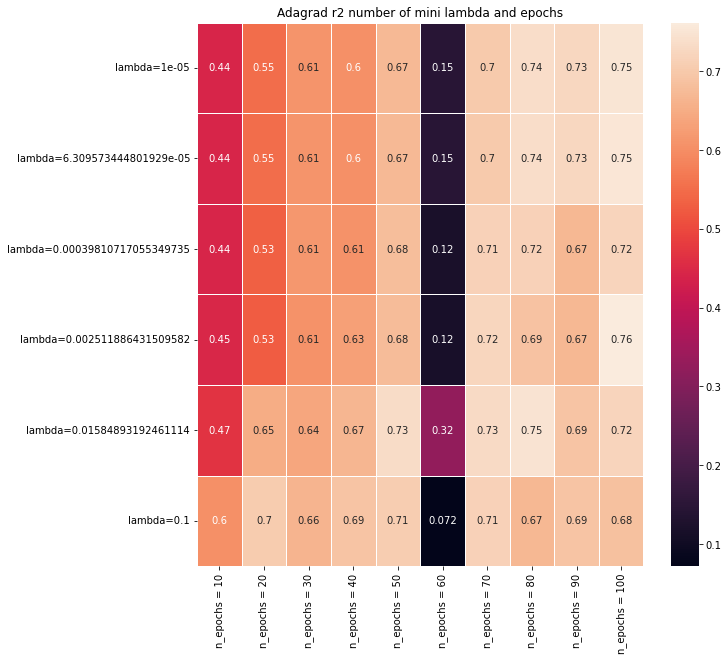

In [82]:
fig, ax = plt.subplots(figsize=(10,10))   
sns.heatmap(df_r2_heatmap_adg_epoc_lmb,annot =True, linewidths=.8, ax=ax,fmt='.2g')
ax.set_title("Adagrad r2 number of mini lambda and epochs")

Text(0.5, 1.0, 'Adam r2 number of mini lambda and epochs')

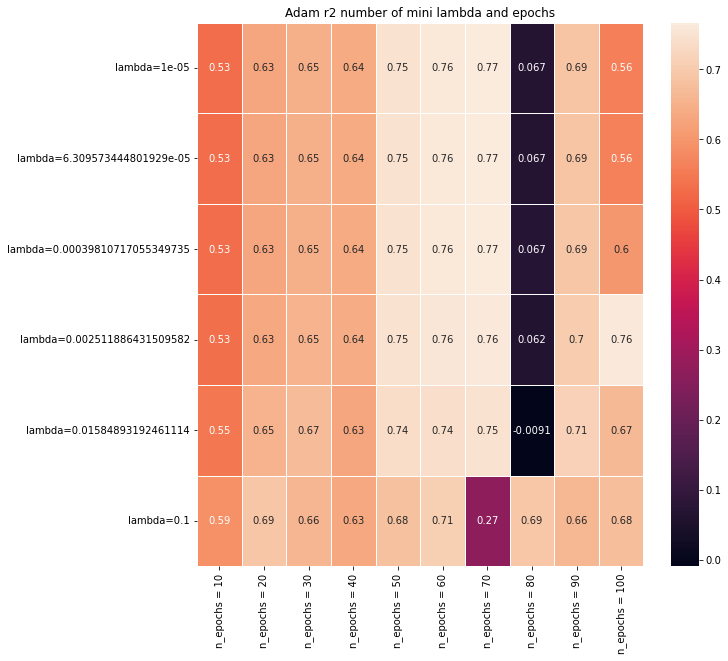

In [83]:
fig, ax = plt.subplots(figsize=(10,10))   
sns.heatmap(df_r2_heatmap_adm_epoc_lmb,annot =True, linewidths=.8, ax=ax,fmt='.2g')
ax.set_title("Adam r2 number of mini lambda and epochs")

Text(0.5, 1.0, 'RMS r2 number of mini lambda and epochs')

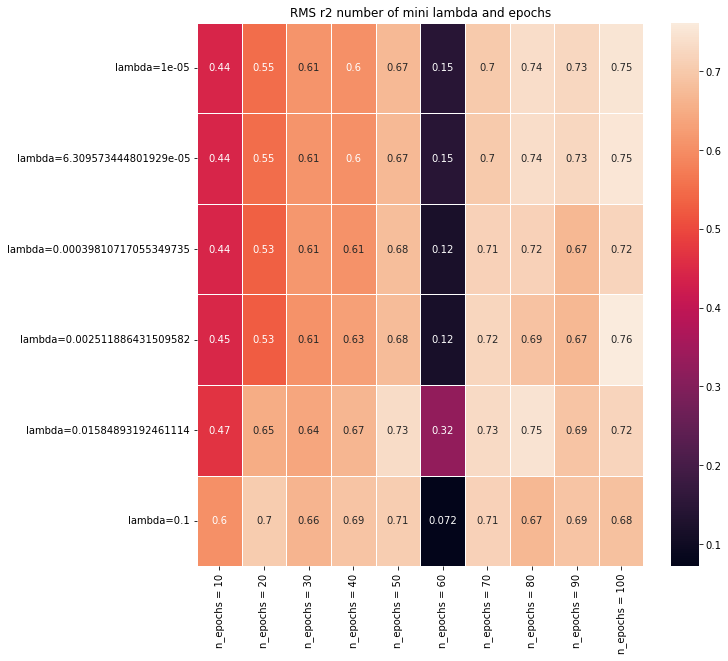

In [84]:
fig, ax = plt.subplots(figsize=(1,10))   
sns.heatmap(df_r2_heatmap_rms_epoc_lmb,annot =True, linewidths=.8, ax=ax,fmt='.2g')
ax.set_title("RMS r2 number of mini lambda and epochs")

# Comparing all the methods

In [133]:
n_epochs_list = np.arange(0,100,1)
etas = np.logspace(-5,-1,5)
mse_test_mom_comp = []
mse_test_adg_comp = []
mse_test_rms_comp = []
mse_test_adm_comp = []


r2_test_mom_comp = []
r2_test_adg_comp = []
r2_test_rms_comp = []
r2_test_adm_comp = []


theta_j = 0
lr = 0
batch_size = 20
for j in range(100+1):
    n_epochs = j
    theta_rms = SGD_ridge(X_train,z_train,n_epochs = n_epochs,batch_size = batch_size,lmb = RMS_opti[0],algo = "RMS", eta = RMS_opti[1])
    theta_mom = SGD_ridge(X_train,z_train,n_epochs = n_epochs,batch_size = batch_size,lmb = MOM_opti[0],gamma = 0.9,algo = "MOM",eta= MOM_opti[1])
    theta_adg = SGD_ridge(X_train,z_train,n_epochs = n_epochs,batch_size = batch_size,lmb = ADG_opti[0],algo = "ADG",eta=ADG_opti[1])
    theta_adm = SGD_ridge(X_train,z_train,n_epochs = n_epochs,batch_size = batch_size,lmb = ADM_opti[0],algo = "ADM",eta=ADM_opti[1])


    z_pred_mom = X_test @ theta_mom
    z_pred_rms = X_test @ theta_rms
    z_pred_adg = X_test @ theta_adg
    z_pred_adm = X_test @ theta_adm

               
    mse_test_rms_comp.append(mean_squared_error(z_test,z_pred_rms))
    mse_test_mom_comp.append(mean_squared_error(z_test,z_pred_mom))
    mse_test_adg_comp.append(mean_squared_error(z_test,z_pred_adg))
    mse_test_adm_comp.append(mean_squared_error(z_test,z_pred_adm))
    
    r2_test_rms_comp.append(r2_score(z_test,z_pred_rms))
    r2_test_mom_comp.append(r2_score(z_test,z_pred_mom))
    r2_test_adg_comp.append(r2_score(z_test,z_pred_adg))
    r2_test_adm_comp.append(r2_score(z_test,z_pred_adm))



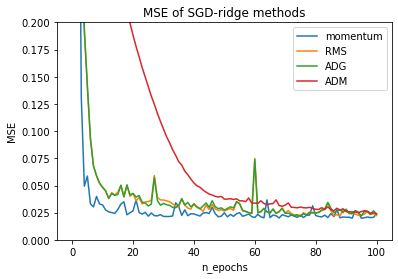

In [134]:
n_epochs_list = np.arange(0,101,1)
plt.plot(n_epochs_list, mse_test_mom_comp, label='momentum')
plt.plot(n_epochs_list, mse_test_rms_comp, label='RMS')
plt.plot(n_epochs_list, mse_test_adg_comp, label='ADG')
plt.plot(n_epochs_list, mse_test_adm_comp, label='ADM')
plt.legend()
plt.xlabel("n_epochs")
plt.ylabel("MSE")
plt.ylim(0,0.2)
plt.title("MSE of SGD-ridge methods")
plt.show()



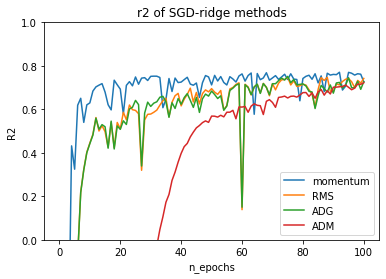

In [135]:
plt.plot(n_epochs_list, r2_test_mom_comp, label='momentum')
plt.plot(n_epochs_list, r2_test_rms_comp, label='RMS')
plt.plot(n_epochs_list, r2_test_adg_comp, label='ADG')
plt.plot(n_epochs_list, r2_test_adm_comp, label='ADM')
plt.legend()
plt.xlabel("n_epochs")
plt.ylabel("R2")
plt.ylim(0,1)
plt.title("r2 of SGD-ridge methods")
plt.show()


In [138]:
n_epochs_list = np.arange(10,110,10)
batch_sizes = [10,16,20,32,40,64,80]

mse_test_mom_size = np.zeros((len(batch_sizes),len(n_epochs_list)))
mse_test_adg_size = np.zeros((len(batch_sizes),len(n_epochs_list)))
mse_test_rms_size = np.zeros((len(batch_sizes),len(n_epochs_list)))
mse_test_adm_size = np.zeros((len(batch_sizes),len(n_epochs_list)))



r2_test_mom_size = np.zeros((len(batch_sizes),len(n_epochs_list)))
r2_test_adg_size = np.zeros((len(batch_sizes),len(n_epochs_list)))
r2_test_rms_size = np.zeros((len(batch_sizes),len(n_epochs_list)))
r2_test_adm_size = np.zeros((len(batch_sizes),len(n_epochs_list)))
theta_j = 0
lr = 0
for i in range(len(batch_sizes)):
    batch_size = batch_sizes[i]
    for j in range(len(n_epochs_list)):

        n_epochs = n_epochs_list[j]
        theta_rms = SGD_ridge(X_train,z_train,n_epochs = n_epochs,batch_size = batch_size,lmb = RMS_opti[0],algo = "RMS", eta = RMS_opti[1])
        theta_mom = SGD_ridge(X_train,z_train,n_epochs = n_epochs,batch_size = batch_size,lmb = MOM_opti[0],gamma = 0.9,algo = "MOM",eta=MOM_opti[1])
        theta_adg = SGD_ridge(X_train,z_train,n_epochs = n_epochs,batch_size = batch_size,lmb = ADG_opti[0],algo = "ADG",eta=ADG_opti[1])
        theta_adm = SGD_ridge(X_train,z_train,n_epochs = n_epochs,batch_size = batch_size,lmb = ADM_opti[0],algo = "ADM",eta=ADM_opti[1])




        z_pred_mom = X_test @ theta_mom
        z_pred_rms = X_test @ theta_rms
        z_pred_adg = X_test @ theta_adg
        z_pred_adm = X_test @ theta_adm

               
        mse_test_rms_size[i,j] = mean_squared_error(z_test,z_pred_rms)
        mse_test_mom_size[i,j] = mean_squared_error(z_test,z_pred_mom)
        mse_test_adg_size[i,j] = mean_squared_error(z_test,z_pred_adg)
        mse_test_adm_size[i,j] = mean_squared_error(z_test,z_pred_adm)
        
        r2_test_rms_size[i,j] = r2_score(z_test,z_pred_rms)
        r2_test_mom_size[i,j] = r2_score(z_test,z_pred_mom)
        r2_test_adg_size[i,j] = r2_score(z_test,z_pred_adg)
        r2_test_adm_size[i,j] = r2_score(z_test,z_pred_adm)



In [144]:
epoch_list = []
num_minibatch = []
for i in range(len(n_epochs_list)):
    epoch_list.append("n_epochs={}".format(n_epochs_list[i]))
for i in range(len(batch_sizes)):
    num_minibatch.append("mini_batches = {}".format(int(320/batch_sizes[i])))
    
df_mse_heatmap_rms_size = pd.DataFrame(mse_test_rms_size, index = num_minibatch, columns = epoch_list)
df_mse_heatmap_mom_size = pd.DataFrame(mse_test_mom_size, index = num_minibatch, columns = epoch_list)
df_mse_heatmap_adg_size = pd.DataFrame(mse_test_adg_size, index = num_minibatch, columns = epoch_list)
df_mse_heatmap_adm_size = pd.DataFrame(mse_test_adm_size, index = num_minibatch, columns = epoch_list)


df_r2_heatmap_rms_size = pd.DataFrame(r2_test_rms_size, index = num_minibatch, columns = epoch_list)
df_r2_heatmap_mom_size = pd.DataFrame(r2_test_mom_size, index = num_minibatch, columns = epoch_list)
df_r2_heatmap_adg_size = pd.DataFrame(r2_test_adg_size, index = num_minibatch, columns = epoch_list)
df_r2_heatmap_adm_size = pd.DataFrame(r2_test_adm_size, index = num_minibatch, columns = epoch_list)
df_mse_heatmap_rms_size

,n_epochs=10,n_epochs=20,n_epochs=30,n_epochs=40,n_epochs=50,n_epochs=60,n_epochs=70,n_epochs=80,n_epochs=90,n_epochs=100
mini_batches = 32,0.047550,0.046780,0.030860,0.029003,0.023226,0.025153,0.023876,0.024272,0.024910,0.022691
mini_batches = 20,0.050166,0.048710,0.036522,0.023740,0.021958,0.020827,0.024964,0.024385,0.024555,0.024118
mini_batches = 16,0.048243,0.042592,0.036669,0.033393,0.026499,0.074937,0.024513,0.024725,0.027697,0.022398
mini_batches = 10,0.094531,0.041747,0.037256,0.031903,0.025909,0.026788,0.025368,0.025649,0.021169,0.020522
mini_batches = 8,0.051962,0.058252,0.032175,0.027246,0.025388,0.039662,0.022831,0.024527,0.025085,0.054282
mini_batches = 5,0.084567,0.034274,0.037505,0.035575,0.037280,0.047527,0.026868,0.029195,0.032629,0.024293
mini_batches = 4,0.166829,0.037171,0.042333,0.035410,0.026555,0.041796,0.036876,0.024636,0.220770,0.048320


Text(0.5, 1.0, 'Adagrad MSE number of mini batches and epochs')

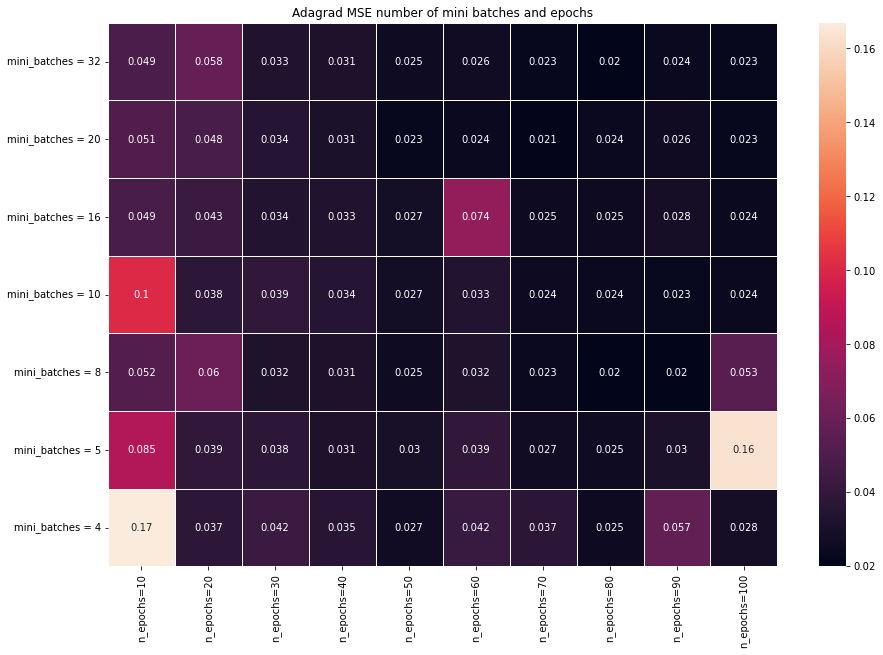

In [140]:
fig, ax = plt.subplots(figsize=(15,10))   
sns.heatmap(df_mse_heatmap_adg_size,annot =True, linewidths=.8, ax=ax,fmt='.2g')
ax.set_title("Adagrad MSE number of mini batches and epochs")

Text(0.5, 1.0, 'Adagrad r2 number of mini batches and epochs')

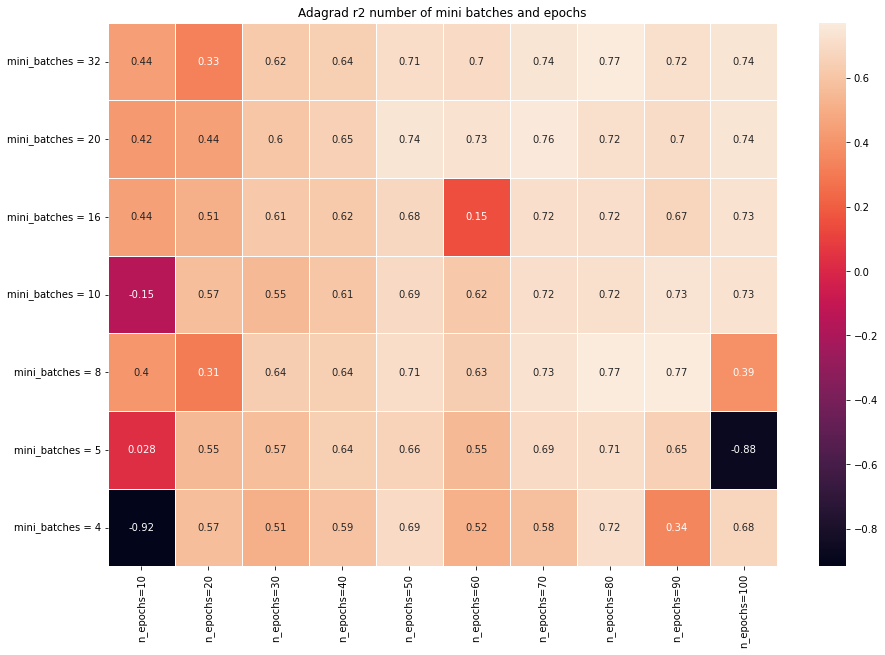

In [145]:
fig, ax = plt.subplots(figsize=(15,10))   
sns.heatmap(df_r2_heatmap_adg_size,annot =True, linewidths=.8, ax=ax,fmt='.2g')
ax.set_title("Adagrad r2 number of mini batches and epochs")

Text(0.5, 1.0, 'momentum MSE number of mini batches and epochs')

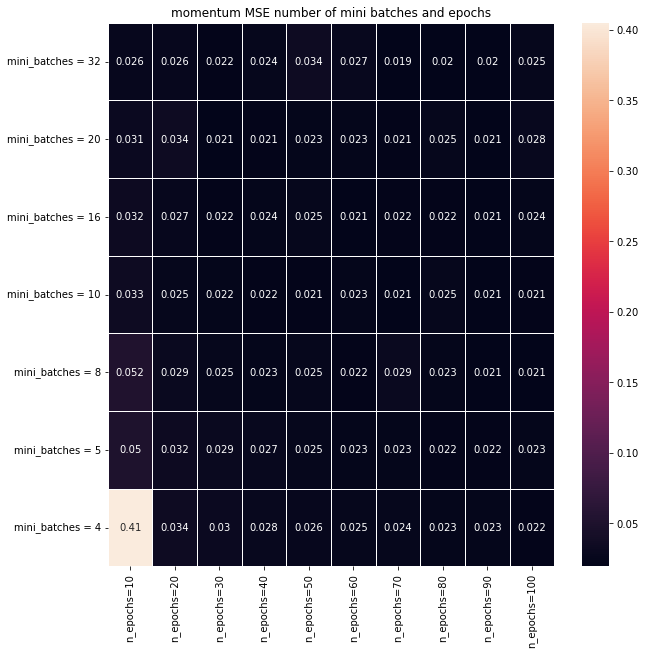

In [149]:
fig, ax = plt.subplots(figsize=(10,10))   
sns.heatmap(df_mse_heatmap_mom_size,annot =True, linewidths=.8, ax=ax,fmt='.2g')
ax.set_title("momentum MSE number of mini batches and epochs")

Text(0.5, 1.0, 'momentum r2 number of mini batches and epochs')

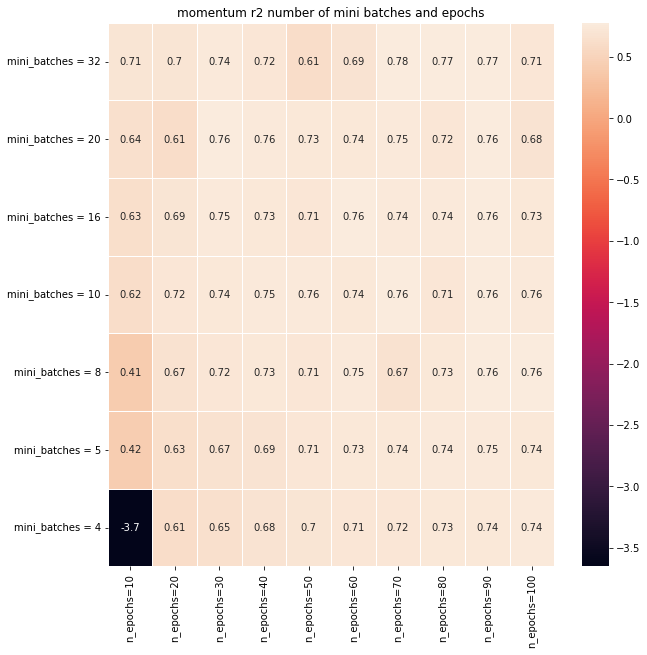

In [151]:
fig, ax = plt.subplots(figsize=(10,10))   
sns.heatmap(df_r2_heatmap_mom_size,annot =True, linewidths=.8, ax=ax,fmt='.2g')
ax.set_title("momentum r2 number of mini batches and epochs")

Text(0.5, 1.0, 'RMS MSE number of mini batches and epochs')

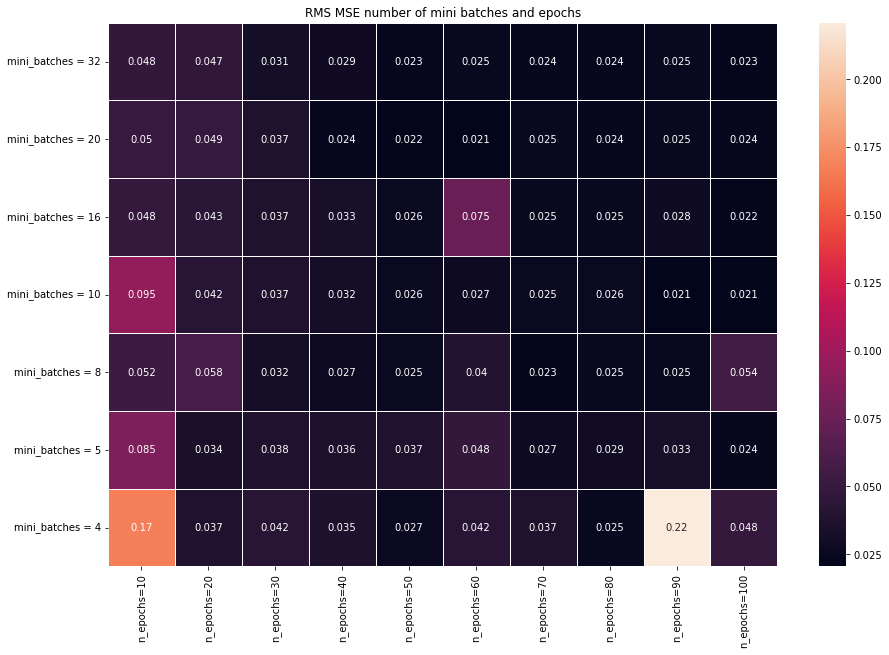

In [142]:
fig, ax = plt.subplots(figsize=(15,10))   
sns.heatmap(df_mse_heatmap_rms_size,annot =True, linewidths=.8, ax=ax,fmt='.2g')
ax.set_title("RMS MSE number of mini batches and epochs")

Text(0.5, 1.0, 'RMS r2 number of mini batches and epochs')

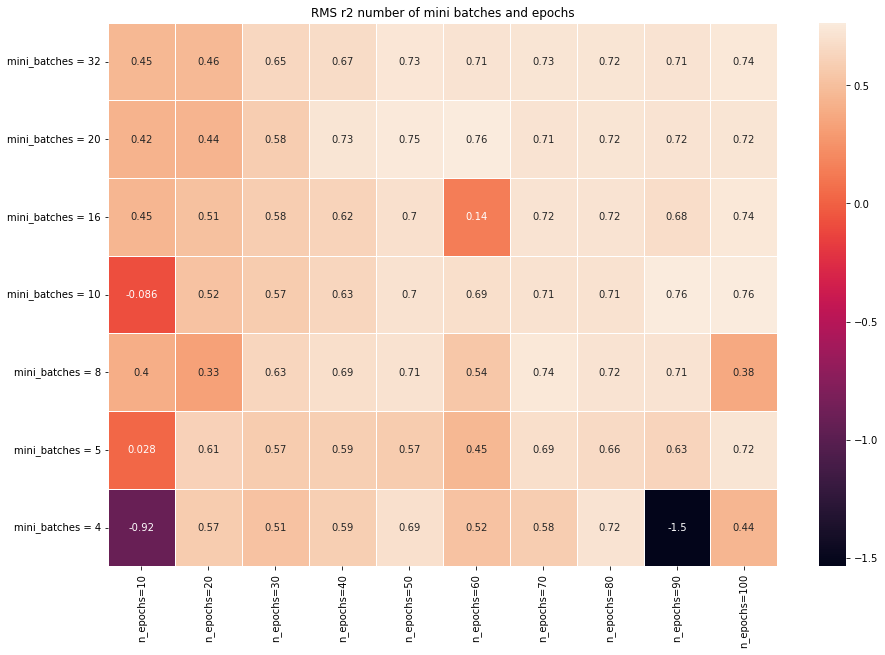

In [147]:
fig, ax = plt.subplots(figsize=(15,10))   
sns.heatmap(df_r2_heatmap_rms_size,annot =True, linewidths=.8, ax=ax,fmt='.2g')
ax.set_title("RMS r2 number of mini batches and epochs")

Text(0.5, 1.0, 'Adam MSE number of mini batches and epochs')

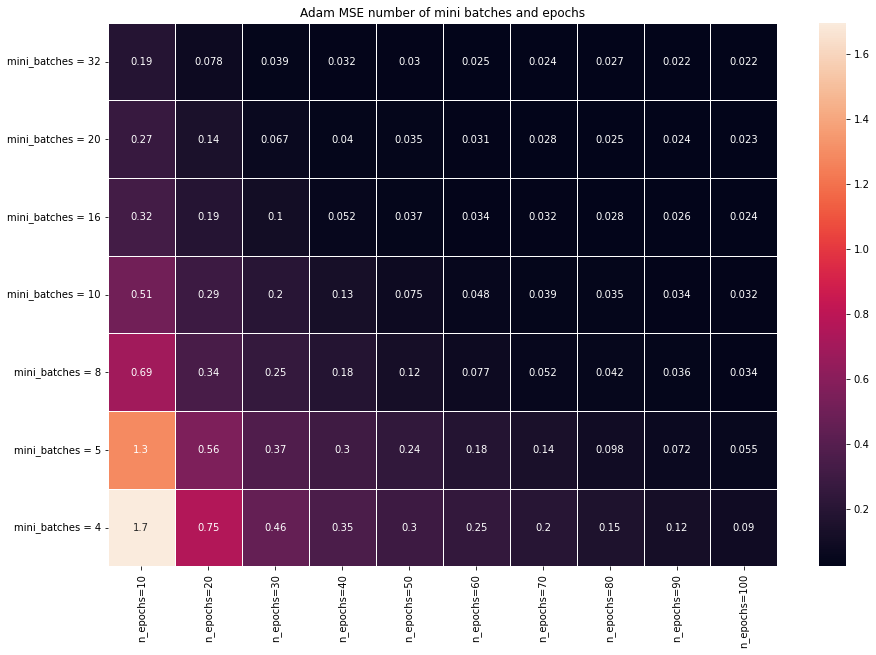

In [143]:

fig, ax = plt.subplots(figsize=(15,10))   
sns.heatmap(df_mse_heatmap_adm_size,annot =True, linewidths=.8, ax=ax,fmt='.2g')
ax.set_title("Adam MSE number of mini batches and epochs")

Text(0.5, 1.0, 'Adam r2 number of mini batches and epochs')

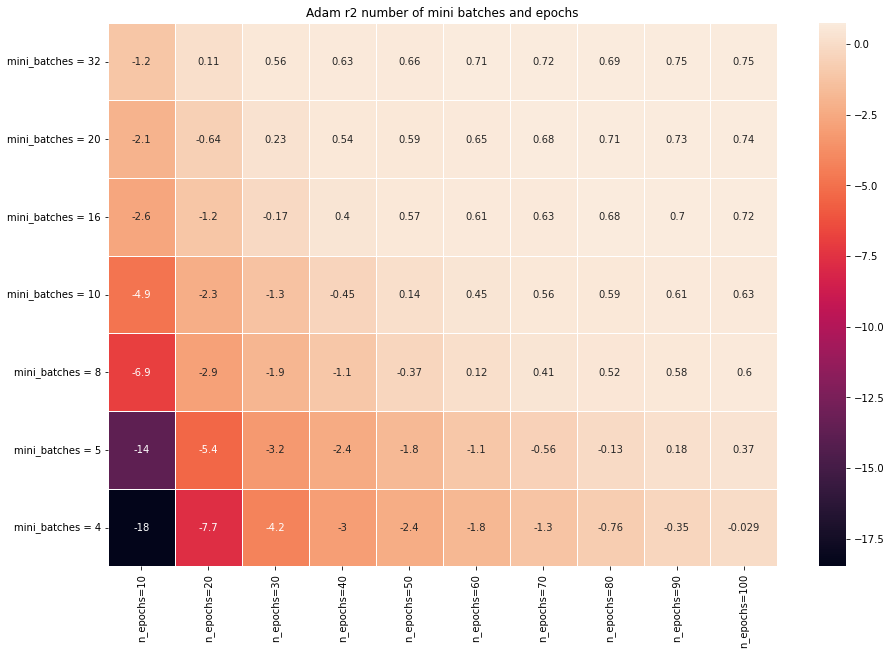

In [148]:
fig, ax = plt.subplots(figsize=(15,10))   
sns.heatmap(df_r2_heatmap_adm_size,annot =True, linewidths=.8, ax=ax,fmt='.2g')
ax.set_title("Adam r2 number of mini batches and epochs")